In [1]:
import os
import json
import random
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
MODEL_PATH = 'trained_model'
MAX_OUTPUT_LENGTH = 140
BEAM_WIDTH = 1

model = load_model(MODEL_PATH + '/model.h5')
params = json.load(open(MODEL_PATH + '/params.json'))
SEQUENCE_LENGTH = params['sequence_length']
char_to_int = params['char_to_int']
labels = {v: k for k, v in params['labels_index'].items()}

W0626 23:48:46.068500  1596 deprecation.py:506] From D:\Anaconda\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
def texts_to_sequences(texts, char_to_int):
    sequences = []
    for text in texts:
        sequences.append([char_to_int[char] for char in text])
    return sequences

def predict_meme(template_id, num_boxes, init_text = ''):
    template_id = str(template_id).zfill(12)
    min_score = 0.1

    final_texts = [{'text': init_text, 'score': 1}]
    finished_texts = []
    
    for char_count in range(len(init_text), MAX_OUTPUT_LENGTH):
        texts = []
        
        for i in range(0, len(final_texts)):
            box_index = str(final_texts[i]['text'].count('|'))
            texts.append(template_id + '  ' + box_index + '  ' + final_texts[i]['text'])
        
        sequences = texts_to_sequences(texts, char_to_int)
        data = pad_sequences(sequences, maxlen=SEQUENCE_LENGTH)
        predictions_list = model.predict(data)
        sorted_predictions = []
        
        for i in range(0, len(predictions_list)):
            for j in range(0, len(predictions_list[i])):
                
                sorted_predictions.append({
                    'text': final_texts[i]['text'],
                    'next_char': labels[j],
                    'score': predictions_list[i][j] * final_texts[i]['score']
                })

        sorted_predictions = sorted(sorted_predictions, key=lambda p: p['score'], reverse=True)
        top_predictions = []
        top_score = sorted_predictions[0]['score']
        rand_int = random.randint(int(min_score * 1000), 1000)
        
        for prediction in sorted_predictions:
            if prediction['score'] >= rand_int / 1000 * top_score:
                top_predictions.append(prediction)
                
        random.shuffle(top_predictions)
        
        final_texts = []
        for i in range(0, min(BEAM_WIDTH, len(top_predictions)) - len(finished_texts)):
            
            prediction = top_predictions[i]
            final_texts.append({
                'text': prediction['text'] + prediction['next_char'],
                'score': prediction['score'] / top_score
            })
            
            if prediction['next_char'] == '|' and prediction['text'].count('|') == num_boxes - 1:
                finished_texts.append(final_texts[len(final_texts) - 1])
                final_texts.pop()

        if char_count >= MAX_OUTPUT_LENGTH - 1 or len(final_texts) == 0:
            final_texts = final_texts + finished_texts
            final_texts = sorted(final_texts, key=lambda p: p['score'], reverse=True)
            return final_texts[0]['text']

||


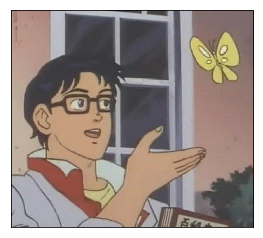

In [4]:
import cv2 
from matplotlib import pyplot as plt
%matplotlib inline

meme_text = predict_meme(100777631,2)

print(meme_text)

meme_text = meme_text.split('|')[:-1]

img = cv2.imread('Is This A Pigeon.jpg')

# Write some Text

font                   = cv2.FONT_HERSHEY_PLAIN 
fontScale              = 3
fontColor              = (255,255,255)
lineType               = 2
thickness              = 5

cv2.putText(img,meme_text[0].upper(), 
    (700,1200), 
    font, 
    fontScale,
    fontColor,
    thickness,
    lineType)

cv2.putText(img,meme_text[1].upper(), 
    (800,200), 
    font, 
    fontScale,
    fontColor,
    thickness,
    lineType)

#Display the image
# cv2.imshow("img",img)

#Save image
cv2.imwrite("ai_meme.jpg", img)

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(rgb)
plt.tick_params(
    axis='both',
    which='both',      
    bottom=False,
    left=False,
    top=False,
    labelleft=False,
    labelbottom=False)
plt.show()